## File and Data Field Descriptions
* ```train.csv``` - Personal records for about two-thirds (~8700) of the pas sengers, to be used as training data.
  * ```PassengerId``` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
  * ```HomePlanet``` - The planet the passenger departed from, typically their planet of permanent residence.
  * ```CryoSleep``` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
  * ```Cabin``` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
  * ```Destination``` - The planet the passenger will be debarking to.
  * ```Age``` - The age of the passenger.
  * ```VIP``` - Whether the passenger has paid for special VIP service during the voyage.
  * ```RoomService```, ```FoodCourt```, ```ShoppingMall```, ```Spa```, ```VRDeck``` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
  * ```Name``` - The first and last names of the passenger.
  * ```Transported``` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
  * ```test.csv``` - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
  * ```sample_submission.csv``` - A submission file in the correct format.
  * ```PassengerId``` - Id for each passenger in the test set.
  * ```Transported``` - The target. For each passenger, predict either True or False.

In [3]:
!pip install kaggle

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached kaggle-1.5.12-py3-none-any.whl
  Using cached python_slugify-7.0.0-py2.py3-none-any.whl (9.4 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)


In [2]:
# All the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from src.data_download import download_data, unzip_data
from src.data_cleaning import DataFrameImputation, ColumnSplitter
from src.scaling_numeric_attr import standardize_numeric_columns

In [3]:
download_data("spaceship-titanic", "/root/.kaggle/kaggle.json")
unzip_data("spaceship-titanic", "/root/spacship-competition/data/raw")

In [4]:
# Read the CSV file and store it in a dataframe 
df_train=pd.read_csv('/root/spacship-competition/data/raw/train.csv')

In [5]:
# Visualize the trianing raw data
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
# Group the data by the VIP attribute with null values and count the number of null values for each group
null_counts = df_train.groupby(['HomePlanet']).apply(lambda x: x.isnull().mean())
# Print the null counts 
print(null_counts)

            PassengerId  HomePlanet  CryoSleep     Cabin  Destination  \
HomePlanet                                                              
Earth               0.0         0.0   0.024772  0.020643     0.021512   
Europa              0.0         0.0   0.027217  0.028625     0.017363   
Mars                0.0         0.0   0.024446  0.021035     0.023877   

                 Age       VIP  RoomService  FoodCourt  ShoppingMall  \
HomePlanet                                                             
Earth       0.019122  0.024989     0.022382   0.021078      0.024337   
Europa      0.021586  0.019709     0.016893   0.021586      0.024871   
Mars        0.024446  0.024446     0.020466   0.021603      0.020466   

                 Spa    VRDeck      Name  Transported  
HomePlanet                                             
Earth       0.021512  0.024120  0.023033          0.0  
Europa      0.021117  0.017363  0.021586          0.0  
Mars        0.020466  0.022172  0.023309         

In [7]:
# Group the data by the VIP attribute with null values and count the number of null values for each group
null_counts = df_train.groupby(['VIP']).apply(lambda x: x.isnull().mean())
# Print the null counts
print(null_counts)

       PassengerId  HomePlanet  CryoSleep     Cabin  Destination       Age  \
VIP                                                                          
False          0.0    0.023278   0.024967  0.022555     0.021228  0.020745   
True           0.0    0.025126   0.015075  0.030151     0.010050  0.005025   

       VIP  RoomService  FoodCourt  ShoppingMall      Spa    VRDeck      Name  \
VIP                                                                             
False  0.0     0.020866   0.020866      0.024002  0.02159  0.022072  0.023640   
True   0.0     0.020101   0.030151      0.025126  0.01005  0.020101  0.015075   

       Transported  
VIP                 
False          0.0  
True           0.0  


In [8]:
# Print the first five rows of the DataFrame
df_train.shape

(8693, 14)

In [9]:
splitter = ColumnSplitter(df=df_train, column='Cabin', sep='/')

In [10]:
splitter.split_column(ordered_required_columns=['deck', 'num', 'side'])

In [11]:
transformer = DataFrameImputation(df_train)
transformer.impute_numeric_columns()
transformer.impute_string_columns()

In [12]:
transformer.extract_features(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'deck', 'num', 'side', 'Transported'])

In [13]:
transformer.df.set_index('PassengerId', inplace=True)

In [14]:
transformer.df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,deck,num,side,Transported
PassengerId,,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P,False
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S,True
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S,False
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S,False
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S,True


In [15]:
transformer.df.isnull().mean()

HomePlanet      0.0
CryoSleep       0.0
Destination     0.0
Age             0.0
VIP             0.0
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
Name            0.0
deck            0.0
num             0.0
side            0.0
Transported     0.0
dtype: float64

In [16]:
# Print a summary of the statistical properties of each numeric column
transformer.df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,7559.000000,7559.000000,7559.000000,7559.000000,7559.000000,7559.000000
mean,28.845786,221.390754,464.825410,176.989546,308.931573,305.228643
std,14.333877,631.582596,1626.531078,561.472975,1117.335557,1116.902994
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,80.000000,122.000000,47.000000,92.000000,74.500000
max,79.000000,9920.000000,29813.000000,12253.000000,22408.000000,20336.000000


In [17]:
standardized_data_frame = standardize_numeric_columns(df=transformer.df)

In [18]:
standardized_data_frame.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,7.559000e+03,7.559000e+03,7.559000e+03,7.559000e+03,7.559000e+03,7.559000e+03
mean,1.313056e-17,-9.965790e-17,-2.523301e-16,-4.767100e-16,2.246443e-16,6.546923e-16
std,1.000066e+00,1.000066e+00,1.000066e+00,1.000066e+00,1.000066e+00,1.000066e+00
min,-2.012553e+00,-3.505565e-01,-2.857961e-01,-3.152445e-01,-2.765078e-01,-2.732993e-01
25%,-6.171653e-01,-3.505565e-01,-2.857961e-01,-3.152445e-01,-2.765078e-01,-2.732993e-01
50%,-1.287794e-01,-3.505565e-01,-2.857961e-01,-3.152445e-01,-2.765078e-01,-2.732993e-01
75%,5.689147e-01,-2.238822e-01,-2.107848e-01,-2.315305e-01,-1.941636e-01,-2.065926e-01
max,3.499230e+00,1.535706e+01,1.804461e+01,2.150916e+01,1.977967e+01,1.793540e+01


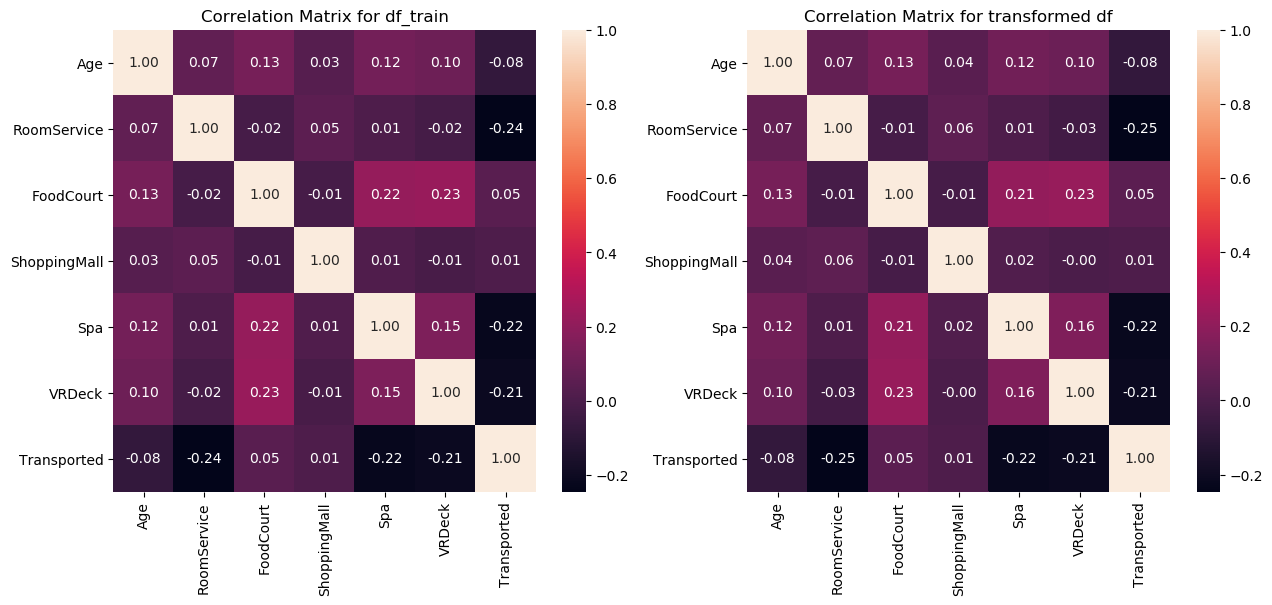

In [19]:
# Create the figure and subplots
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Compute the correlation matrix for the first dataframe
corr1 = df_train.corr()

# Create a heatmap with the correlation numbers for the first dataframe
sns.heatmap(corr1, xticklabels=corr1.columns, yticklabels=corr1.columns, annot=True, fmt='.2f', ax=ax1)
ax1.set_title('Correlation Matrix for df_train')

# Compute the correlation matrix for the second dataframe
corr2 = transformer.df.corr()

# Create a heatmap with the correlation numbers for the second dataframe
sns.heatmap(corr2, xticklabels=corr2.columns, yticklabels=corr2.columns, annot=True, fmt='.2f', ax=ax2)
ax2.set_title('Correlation Matrix for transformed df')

# Show the plot
plt.show()


#### Clean and preprocess the data: Next is cleaning and preprocessing the data to prepare it for analysis. This may include handling missing or null values, converting data types, and scaling numeric attributes.

* Handling missing or null values
* Converting data types
* Scaling numeric attributes

##### When the attributes have very different ranges of values, this can lead to some attributes dominating the model, since their values will be much larger than the values of other attributes.
##### So in this step, it is required to do the following:
* Select the numerical attributes
* Fillin the nulls
* Standardize the range and distribution of numeric attributes if applicable.

#### The null values are evenly distributed throughout the dataset, then dropping the rows may not have a significant impact on the overall distribution of the data.

### Visualizing the null numeric attributes with mean (percentage of nulls in the dataset) - Before and After

#### Before Imputing

In [20]:
df_train.groupby(['HomePlanet']).apply(lambda x: x.isnull().mean())

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side
HomePlanet,,,,,,,,,,,,,,,,,
Earth,0.0,0.0,0.024772,0.020643,0.021512,0.019122,0.024989,0.022382,0.021078,0.024337,0.021512,0.024120,0.023033,0.0,0.020643,0.020643,0.020643
Europa,0.0,0.0,0.027217,0.028625,0.017363,0.021586,0.019709,0.016893,0.021586,0.024871,0.021117,0.017363,0.021586,0.0,0.028625,0.028625,0.028625
Mars,0.0,0.0,0.024446,0.021035,0.023877,0.024446,0.024446,0.020466,0.021603,0.020466,0.020466,0.022172,0.023309,0.0,0.021035,0.021035,0.021035


#### After Imputing

In [21]:
transformer.df.groupby(['HomePlanet']).apply(lambda x: x.isnull().mean())

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,deck,num,side,Transported
HomePlanet,,,,,,,,,,,,,,,
Earth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Europa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mars,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* ```test.csv``` - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

In [22]:
df_test=pd.read_csv('/root/spacship-competition/data/raw/test.csv')

In [23]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


The performance of a machine learning model is required and the test set does not include the target variable that you want to predict.

One approach could be taken is to split the training set further into a new training set and a validation set. Then use the new training set to fit the model and the validation set to evaluate its performance. This way, it is possible to have a set of known true labels (the target variable in the validation set) that can be used to compare with the predicted labels produced by your model.

Another option would be to use a different evaluation metric that does not require true labels for the test set. For example, using a metric like mean squared error (MSE) or root mean squared error (RMSE) to evaluate the performance of the model. These metrics measure the difference between the predicted values and the true values, so they do not require the true labels to be known.

It's also worth noting that in real-world situations, it is not uncommon for the test set to not include the target variable. In these cases, it is essential to use an evaluation metric that does not require the true labels to be known.

The RMSE is a more commonly used metric than the MSE, especially in the field of statistics. It is often used in conjunction with other evaluation metrics, such as the mean absolute error (MAE) or the R-squared value, to provide a more comprehensive evaluation of a model's performance.

In [100]:
X_train_transformer = DataFrameImputation(df_train)
X_train_transformer.impute_numeric_columns()
X_train_transformer.impute_string_columns()
X_train_transformer.extract_features(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'deck', 'num', 'side', 'Transported'])
X_train_transformer.df['num'] = X_train_transformer.df['num'].astype(int)
X_train_transformer.df.set_index('PassengerId', inplace=True)
X_train_standardized = standardize_numeric_columns(df=X_train_transformer.df)
X_train_df = X_train_standardized[X_train_standardized.columns.difference(['Transported'])]

X_train = X_train_df.values
y_train = X_train_standardized['Transported'].values

In [102]:
test_splitter = ColumnSplitter(df=df_test, column='Cabin', sep='/')
test_splitter.split_column(ordered_required_columns=['deck', 'num', 'side'])

X_test_transformer = DataFrameImputation(df_test)
X_test_transformer.impute_numeric_columns()
X_test_transformer.impute_string_columns()
X_test_transformer.extract_features(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'deck', 'num', 'side'])
X_test_transformer.df['num'] = X_test_transformer.df['num'].astype(int)
X_test_transformer.df.set_index('PassengerId', inplace=True)

X_test_standardized = standardize_numeric_columns(df=X_test_transformer.df)

In [103]:
# Find the object like dtypes
X_train_df.dtypes == 'object'

Age             False
CryoSleep        True
Destination      True
FoodCourt       False
HomePlanet       True
RoomService     False
ShoppingMall    False
Spa             False
VIP              True
VRDeck          False
deck             True
num             False
side             True
dtype: bool

In [104]:
# Assume the data is stored in a Pandas dataframe called df
X_train_categorical = X_train_standardized[['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side']]
X_test_categorical = X_test_standardized[['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side']]
# Create an instance of the OneHotEncoder class
one_hot_encoder = OneHotEncoder()

In [105]:
# Use the fit_transform method to apply one-hot encoding to the categorical columns
X_train_one_hot = one_hot_encoder.fit_transform(X_train_categorical)
X_test_one_hot = one_hot_encoder.fit_transform(X_test_categorical)

In [106]:
# The resulting array has two columns: one for each possible category in the Cabin column
print(f"One hot-encoded categorical features' shape: Trainig = {X_train_one_hot.shape}, Testing = {X_test_one_hot.shape}")

One hot-encoded categorical features' shape: Trainig = (7559, 20), Testing = (3747, 20)


In [107]:
# Convert the one-hot encoded data to a Pandas dataframe
X_train_one_hot_df = pd.DataFrame(X_train_one_hot.toarray(), columns=one_hot_encoder.get_feature_names())
X_test_one_hot_df = pd.DataFrame(X_test_one_hot.toarray(), columns=one_hot_encoder.get_feature_names())

In [108]:
# Concatenate the one-hot encoded data with the original dataframe
train_df_encoded = pd.concat([X_train_df.reset_index(drop=True), X_train_one_hot_df.reset_index(drop=True)], axis=1)
test_df_encoded = pd.concat([X_test_transformer.df.reset_index(drop=True), X_test_one_hot_df.reset_index(drop=True)], axis=1)

In [109]:
train_df_encoded = train_df_encoded.drop(columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side'])
test_df_encoded = test_df_encoded.drop(columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side'])

In [110]:
# Extract the desired features from the testing set
X_train = train_df_encoded.values
# Extract the desired features from the testing set
X_test = test_df_encoded.values

In [111]:
X_train.shape, y_train.shape, X_test.shape

((7559, 27), (7559,), (3747, 27))

In [112]:
train_df_encoded.isnull().sum()

Age                 0
FoodCourt           0
RoomService         0
ShoppingMall        0
Spa                 0
VRDeck              0
num                 0
x0_Earth            0
x0_Europa           0
x0_Mars             0
x1_False            0
x1_True             0
x2_55 Cancri e      0
x2_PSO J318.5-22    0
x2_TRAPPIST-1e      0
x3_False            0
x3_True             0
x4_A                0
x4_B                0
x4_C                0
x4_D                0
x4_E                0
x4_F                0
x4_G                0
x4_T                0
x5_P                0
x5_S                0
dtype: int64

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

# Create a logistic regression model
model = LogisticRegression(solver='liblinear')

# # Train the model using the training data
# model.fit(X_train, y_train)

# scores = cross_val_score(model, X_train, y_train, cv=10)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(model, X_train, y_train, cv=kfold)

In [114]:
scores

array([0.80555556, 0.7989418 , 0.78108466, 0.78108466, 0.78557247])

In [115]:
from sklearn.metrics import accuracy_score

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [116]:
y_pred

array([False, False, False, ...,  True,  True,  True])